# Performance
We compared our low-cost UBC - PM sensors to an industry-standard GRIMM OPC sensor (Model: 1.109). For the comparison, saltwater solutions with known molar concentrations were fed into an atomizer. The atomizer separated/produced air-borne salt particles that traveled through an adjustable filter and into a 22L glass chamber containing the five UBC – PM Sensors and a small fan to mix the air (Figure 4CR). Simultaneously, the Grimm OPC sensor pulled air from the glass chamber to sample particle concentrations. The chamber also had an exhaust port to help maintain consistent concentration levels.
<br>
<br>
<img src="_static/img/chamber.jpeg" alt="chamber" width="300"/>
<br>
<br>

The primary objective was to compare the UBC - PM Sensor's static and dynamic response to the GRIMM instrument. To accomplish this, adjustments to the inflow filter were made to moderate the concentrations of particles entering the chamber. An appropriate amount of time was given so that the concentration levels stabilize. Sampling time ranged between 15-30 minutes. Concentration values were varied so that a calibration curve could be derived and then applied to the UBC – PM sensors to correlate to the GRIMM measured values. In developing the calibration cure it was assumed that the GRIMM OPC provided a true measure of PM concentrations.
<br>
<br>
We conducted 16.5 hours of sampling over a two-day period. The GRIMM and UBC – PM sensors sample at one minute and 1.6 seconds, respectively. The UBC - PM sensors were time-averaged to the same one-minute sampling period of the GRIMM instrument for comparison. Of the five UBC – PM sensors, one malfunctioned and reported erroneous values and was removed from the study. 
<br>
<br>
Lets Dive in and assess the the first 12 hours of sampling data (obtained on day one).

In [1]:
import context
import pickle
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from matplotlib.offsetbox import AnchoredText
import matplotlib.pylab as pylab
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy import stats

from datetime import datetime, timedelta
from pathlib import Path
from context import data_dir, save_dir

# Back pratices but this keeps the notebook clean when displaying on html
import warnings
warnings.filterwarnings("ignore")

******************************
context imported. Front of path:
/Users/rodell/Documents/Arduino
/Users/rodell/Documents/Arduino/docs/source
******************************

through /Users/rodell/Documents/Arduino/docs/source/context.py -- pha



## Import OPC data!
UBC AQ data was one minute averaged to match the GRIMM sample rate.

In [2]:

## define date of interest
date_of_int = '20210430' # options 20210430 or 20210502


def prepare_df(ubc_pm, date_of_int):
  """
  Function cleans UBC OPCs data by removing duplicate headers and dropping error values. 
  Once cleaned takes 1 min avg of data to match GRIM sample rate.
  """
  df = pd.read_csv(str(data_dir) + ubc_pm + date_of_int + '.TXT')
  df = df.drop(df[df.rtctime == 'rtctime'].index)
  df = df[~df['pm10_env'].str.contains('Rec')]
  time = pd.to_datetime(df['rtctime'])
  df.index = pd.DatetimeIndex(pd.to_datetime(df['rtctime']))
  df = df.drop(['rtctime'], axis=1)
  df = df.astype(float)
  df = df[df['pm10_env'] < 4000]
  df = df[df['pm25_env'] < 4000]
  df = df[df['pm100_env'] < 4000]

  df = df.resample('1Min').mean()

  col = ubc_pm.strip('/').replace('-','_')
  new_name = {}
  for name in list(df):
    new_name.update({name : col+'_'+name} )
  df = df.rename(new_name, axis='columns')

  return df



Open the ubc opcs

In [3]:

ubc_list = [prepare_df(f"/UBC-PM-0{i}/", date_of_int) for i in range(1,6)]
df_ubc = reduce(lambda x, y: pd.merge(x, y, on='rtctime'), ubc_list)
df_ubc.columns = df_ubc.columns.str.replace('_y', '')

Open the grim opc

In [4]:
def open_grimm(date_of_int, min_ubc):
  try:
    df_grim = pd.read_csv(str(data_dir) + f'/GRIM/{date_of_int}.csv')
    df_grim['date & time'] = pd.to_datetime(df_grim['date & time'])
  except:
    pathlist = sorted(Path(str(data_dir) + '/2021_OPCintercomparison/').glob(f'{date_of_int}*'))
    sheets = ['PM values', 'Count values', 'Mass values', 'Log values']
    df_grim = [pd.read_excel(f'{pathlist[0]}/{pathlist[0].stem}_sample01.xlsx', sheet_name= sheet, skiprows=4, engine='openpyxl') for sheet in sheets]
    df_grim = reduce(lambda x, y: pd.merge(x, y, on='date & time'), df_grim)
    df_grim['date & time'] = pd.to_datetime(df_grim['date & time'], dayfirst=True)
    df_grim.to_csv(str(data_dir) + f'/GRIM/{date_of_int}.csv', index=False)


  df_grim['date & time'] = df_grim['date & time'].dt.round('1min')  
  df_grim = df_grim.set_index('date & time')
  df_grim = df_grim.join(min_ubc, how='outer')
  df_grim = df_grim.dropna()
  return df_grim

min_ubc = np.argmin([len(ubc_list[i]) for i in range(len(ubc_list))])
df_grim = open_grimm(date_of_int, ubc_list[min_ubc])

Merge UBC dfs with Grimm df and print first five rows 

In [5]:
df_final = pd.merge(left=df_grim, right=df_ubc, left_index=True, right_index=True, how='left')
df_final.columns = df_final.columns.str.replace('_y', '')
df_final.head()

,PM10 [ug/m3],PM2.5 [ug/m3],PM1 [ug/m3],Inhalable [ug/m3],Thoracic [ug/m3],Alveolic [ug/m3],0.25 um_x,0.28 um_x,0.30 um_x,0.35 um_x,...,UBC_PM_05_pm25_standard,UBC_PM_05_pm100_standard,UBC_PM_05_particles_03um,UBC_PM_05_particles_05um,UBC_PM_05_particles_10um,UBC_PM_05_particles_25um,UBC_PM_05_particles_50um,UBC_PM_05_particles_100um,UBC_PM_05_TX_batvolt,UBC_PM_05_RX_batvolt
2021-04-30 09:27:00,18.8,18.8,18.7,18.8,18.8,18.8,257654.0,104605.0,23570.0,7505.0,...,0.0,0.0,209.750000,58.125000,9.250000,0.0,0.0,0.0,4.320208,4.274375
2021-04-30 09:28:00,19.1,19.1,19.0,19.1,19.1,19.1,267314.0,107470.0,23815.0,7135.0,...,0.0,0.0,159.319149,43.531915,5.234043,0.0,0.0,0.0,4.320000,4.272766
2021-04-30 09:29:00,19.6,19.6,19.5,19.6,19.6,19.6,278557.0,110995.0,23810.0,7395.0,...,0.0,0.0,191.361702,56.936170,4.978723,0.0,0.0,0.0,4.320426,4.275745
2021-04-30 09:30:00,19.6,19.6,19.5,19.6,19.6,19.6,285831.0,111255.0,23620.0,7360.0,...,0.0,0.0,162.255319,48.255319,7.234043,0.0,0.0,0.0,4.320213,4.274255
2021-04-30 09:31:00,20.0,20.0,20.0,20.0,20.0,20.0,298343.0,115235.0,23745.0,7190.0,...,0.0,0.0,231.319149,60.893617,8.510638,0.0,0.0,0.0,4.320426,4.274468


Define default font sizes for ploting

In [6]:
params = {
         'xtick.labelsize':14,
         'ytick.labelsize': 14,
          'axes.labelsize':14,

         }

pylab.rcParams.update(params)

### Plot PM 1.0 

Text(0.5, 0, '$\\frac{\\mu g}{m^3}$')

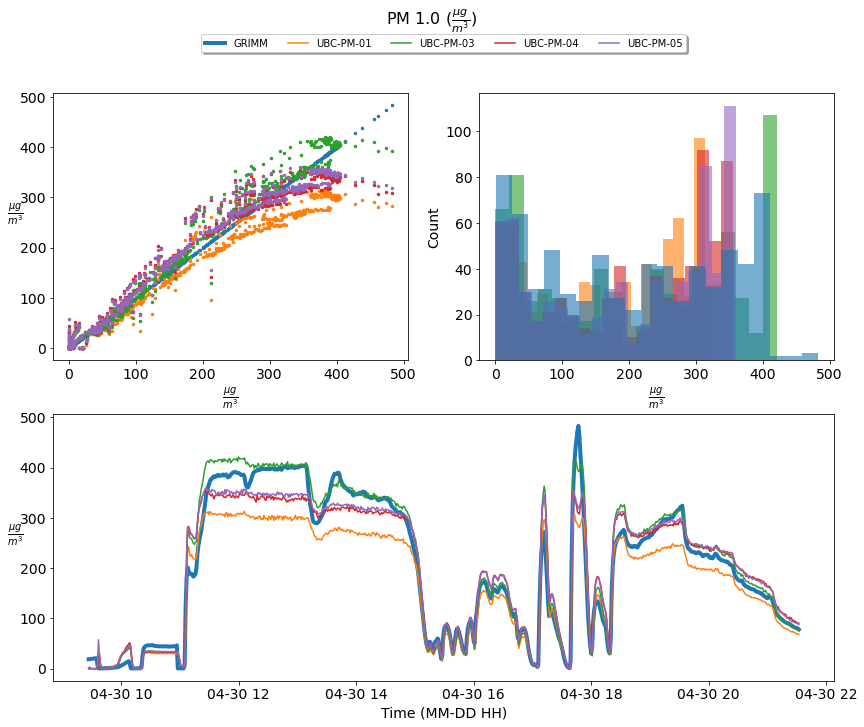

In [7]:

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


fig = plt.figure(figsize=(14, 12))
fig.autofmt_xdate()
xfmt = DateFormatter("%m-%d %H:00")
fig.suptitle(r"PM 1.0 ($\frac{\mu g}{m^3}$)", fontsize=16)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df_final.index,df_final['PM1 [ug/m3]'], lw = 4.0, label = 'GRIMM', color = colors[0])
ax.plot(df_final.index,df_final['UBC_PM_01_pm10_env'], label = 'UBC-PM-01', color = colors[1])
# ax.plot(df_final.index,df_final['UBC_PM_02_pm10_env'], label = 'UBC-PM-02', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_03_pm10_env'], label = 'UBC-PM-03', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_04_pm10_env'], label = 'UBC-PM-04', color = colors[3])
ax.plot(df_final.index,df_final['UBC_PM_05_pm10_env'], label = 'UBC-PM-05', color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 2.44),
    ncol=6,
    fancybox=True,
    shadow=True,
)
ax = fig.add_subplot(2, 2, 1)
size = 6
ax.scatter(df_final['PM1 [ug/m3]'], df_final['PM1 [ug/m3]'], s=size, color = colors[0])
ax.scatter(df_final['PM1 [ug/m3]'], df_final['UBC_PM_01_pm10_env'], s=size, color = colors[1])
# ax.scatter(df_grim['PM1 [ug/m3]'], df_final['UBC_PM_02_pm10_env'], s=size, color = colors[2])
ax.scatter(df_final['PM1 [ug/m3]'], df_final['UBC_PM_03_pm10_env'], s=size, color = colors[2])
ax.scatter(df_final['PM1 [ug/m3]'], df_final['UBC_PM_04_pm10_env'], s=size, color = colors[3])
ax.scatter(df_final['PM1 [ug/m3]'], df_final['UBC_PM_05_pm10_env'], s=size, color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

ax = fig.add_subplot(2, 2, 2)
bins = 20
alpha = 0.6
ax.hist(df_final['PM1 [ug/m3]'],bins,alpha = alpha, color = colors[0], zorder = 10)
ax.hist(df_final['UBC_PM_01_pm10_env'],bins, alpha = alpha, color = colors[1])
# ax.hist(df_final['UBC_PM_02_pm10_env'],bins, alpha = alpha,color = colors[2])
ax.hist(df_final['UBC_PM_03_pm10_env'],bins, alpha = alpha, color = colors[2])
ax.hist(df_final['UBC_PM_04_pm10_env'],bins, alpha = alpha,color = colors[3])
ax.hist(df_final['UBC_PM_05_pm10_env'],bins, alpha = alpha, color = colors[4])
ax.set_ylabel('Count')
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

Figure 1; scatter plots, histograms, and a times series comparison of the measured PM 1.0 concentration of four UBC- PM Sensors [UBC-PM-01 (orange), UBC-PM-03 (green), UBC-PM-04 (red), UBC-PM-05 (purple)] and the GRIM sensor [GRIMM (blue)]. The time series shows one-minute averaged PM 1.0 concentrations incremented from 2021-04-30 09:27:00 until 2021-04-30 21:36:00

### Plot PM 2.5 

Text(0.5, 0, '$\\frac{\\mu g}{m^3}$')

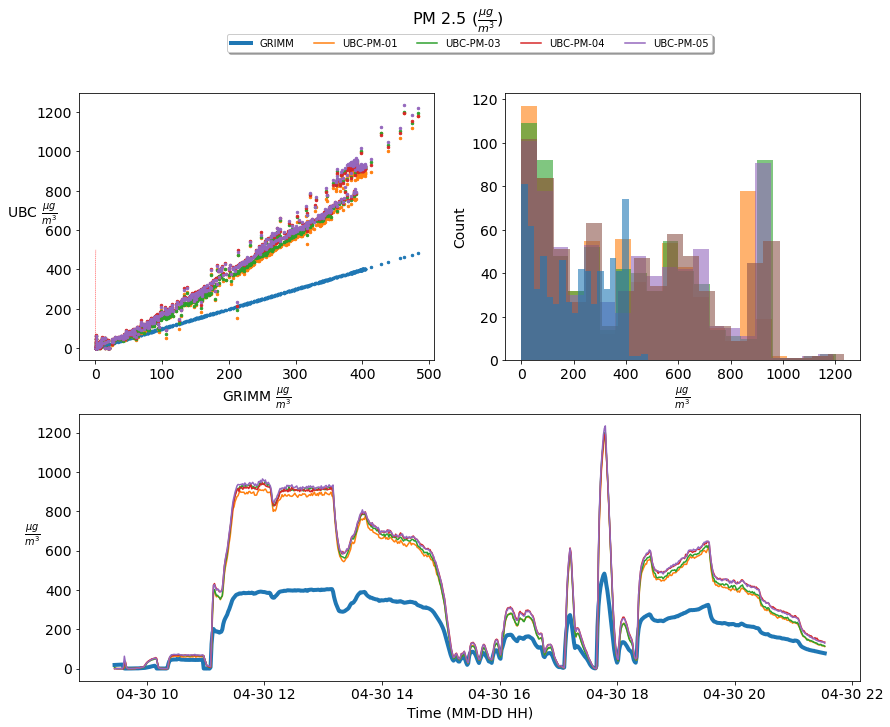

In [8]:


fig = plt.figure(figsize=(14, 12))
fig.autofmt_xdate()
xfmt = DateFormatter("%m-%d %H:00")
fig.suptitle(r"PM 2.5 ($\frac{\mu g}{m^3}$)", fontsize=16)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df_final.index,df_final['PM2.5 [ug/m3]'], lw = 4.0, label = 'GRIMM', color = colors[0])
ax.plot(df_final.index,df_final['UBC_PM_01_pm25_env'], label = 'UBC-PM-01', color = colors[1])
# ax.plot(df_final.index,df_final['UBC_PM_02_pm10_env'], label = 'UBC-PM-02', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_03_pm25_env'], label = 'UBC-PM-03', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_04_pm25_env'], label = 'UBC-PM-04', color = colors[3])
ax.plot(df_final.index,df_final['UBC_PM_05_pm25_env'], label = 'UBC-PM-05', color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 2.44),
    ncol=6,
    fancybox=True,
    shadow=True,
)
ax = fig.add_subplot(2, 2, 1)
size = 6
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['PM2.5 [ug/m3]'], s=size, color = colors[0])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['UBC_PM_01_pm25_env'], s=size, color = colors[1])
# ax.scatter(df_grim['PM2.5 [ug/m3]'], df_final['UBC_PM_02_pm25_env'], s=size, color = colors[2])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['UBC_PM_03_pm25_env'], s=size, color = colors[2])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['UBC_PM_04_pm25_env'], s=size, color = colors[3])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['UBC_PM_05_pm25_env'], s=size, color = colors[4])
ax.set_ylabel(r'UBC $\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel(r'GRIMM $\frac{\mu g}{m^3}$')
ax.plot((0, 500), "r--", lw= 0.4)

ax = fig.add_subplot(2, 2, 2)
bins = 20
alpha = 0.6
ax.hist(df_final['PM2.5 [ug/m3]'],bins,alpha = alpha, color = colors[0], zorder = 10)
ax.hist(df_final['UBC_PM_01_pm25_env'],bins, alpha = alpha, color = colors[1])
# ax.hist(df_final['UBC_PM_02_pm25_env'],bins, alpha = alpha,color = colors[2])
ax.hist(df_final['UBC_PM_03_pm25_env'],bins, alpha = alpha, color = colors[2])
ax.hist(df_final['UBC_PM_04_pm25_env'],bins, alpha = alpha,color = colors[4])
ax.hist(df_final['UBC_PM_05_pm25_env'],bins, alpha = alpha, color = colors[5])
ax.set_ylabel('Count')
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

Figure 2; scatter plots, histograms, and a times series comparison of the measured PM 2.5 concentration of four UBC- PM Sensors [UBC-PM-01 (orange), UBC-PM-03 (green), UBC-PM-04 (red), UBC-PM-05 (purple)] and the GRIM sensor [GRIMM (blue)]. The time series shows one-minute averaged PM 2.5 concentrations incremented from 2021-04-30 09:27:00 until 2021-04-30 21:36:00

### Plot PM 10 

Text(0.5, 0, '$\\frac{\\mu g}{m^3}$')

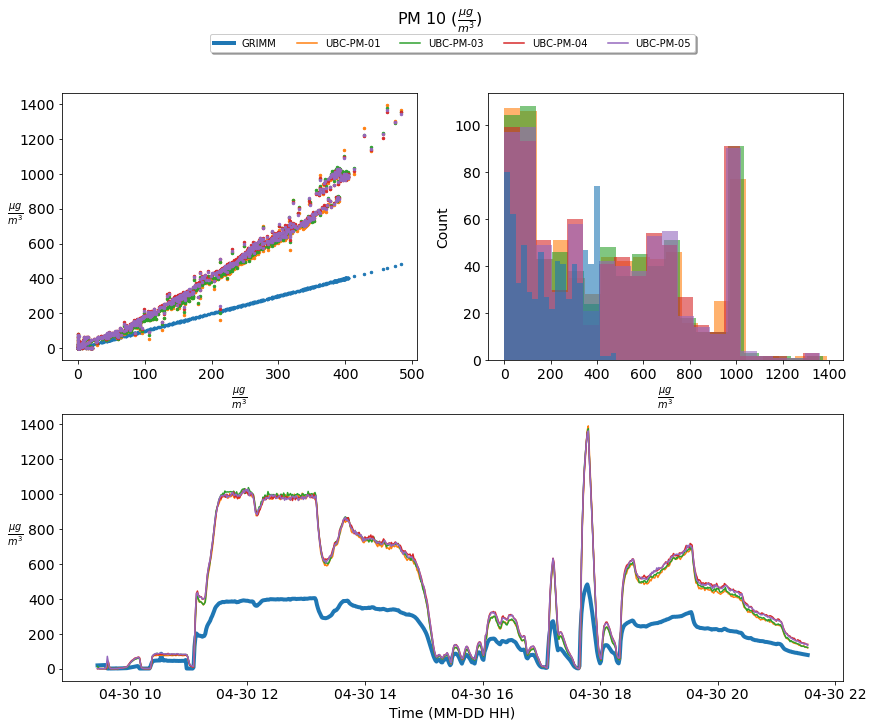

In [9]:

fig = plt.figure(figsize=(14, 12))
fig.autofmt_xdate()
xfmt = DateFormatter("%m-%d %H:00")
fig.suptitle(r"PM 10 ($\frac{\mu g}{m^3}$)", fontsize=16)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df_final.index,df_final['PM10 [ug/m3]'], lw = 4.0, label = 'GRIMM', color = colors[0])
ax.plot(df_final.index,df_final['UBC_PM_01_pm100_env'], label = 'UBC-PM-01', color = colors[1])
# ax.plot(df_final.index,df_final['UBC_PM_02_pm100_env'], label = 'UBC-PM-02', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_03_pm100_env'], label = 'UBC-PM-03', color = colors[2])
ax.plot(df_final.index,df_final['UBC_PM_04_pm100_env'], label = 'UBC-PM-04', color = colors[3])
ax.plot(df_final.index,df_final['UBC_PM_05_pm100_env'], label = 'UBC-PM-05', color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 2.44),
    ncol=6,
    fancybox=True,
    shadow=True,
)
ax = fig.add_subplot(2, 2, 1)
size = 6
ax.scatter(df_final['PM10 [ug/m3]'], df_final['PM10 [ug/m3]'], s=size, color = colors[0])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['UBC_PM_01_pm100_env'], s=size, color = colors[1])
# ax.scatter(df_grim['PM10 [ug/m3]'], df_final['UBC_PM_02_pm100_env'], s=size, color = colors[2])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['UBC_PM_03_pm100_env'], s=size, color = colors[2])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['UBC_PM_04_pm100_env'], s=size, color = colors[3])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['UBC_PM_05_pm100_env'], s=size, color = colors[4])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

ax = fig.add_subplot(2, 2, 2)
bins = 20
alpha = 0.6
ax.hist(df_final['PM10 [ug/m3]'],bins,alpha = alpha, color = colors[0], zorder = 10)
ax.hist(df_final['UBC_PM_01_pm100_env'],bins, alpha = alpha, color = colors[1])
# ax.hist(df_final['UBC_PM_02_pm10_env'],bins, alpha = alpha,color = colors[2])
ax.hist(df_final['UBC_PM_03_pm100_env'],bins, alpha = alpha, color = colors[2])
ax.hist(df_final['UBC_PM_04_pm100_env'],bins, alpha = alpha,color = colors[3])
ax.hist(df_final['UBC_PM_05_pm100_env'],bins, alpha = alpha, color = colors[4])
ax.set_ylabel('Count')
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

Figure 3; scatter plots, histograms, and a times series comparison of the measured PM 10 concentration of four UBC- PM Sensors [UBC-PM-01 (orange), UBC-PM-03 (green), UBC-PM-04 (red), UBC-PM-05 (purple)] and the GRIM sensor [GRIMM (blue)]. The time series shows one-minute averaged PM 10 concentrations incremented from 2021-04-30 09:27:00 until 2021-04-30 21:36:00

## Preliminary Results
Based upon the above graphics the UBC- PM sensors perform acceptably at PM 1.0 concentrations; however, they significantly over-predict the concentration levels of PM 2.5 and 10. 
<br>
To understand why this occurred let's looked at a time series of the GRIMM PM 1.0, 2.5 and 10 and the particle size distribution.

### Plot time series PM 1.0, 2.5 and 10 from the GRIMM sensor.

Text(0.5, 0, '$\\frac{\\mu g}{m^3}$')

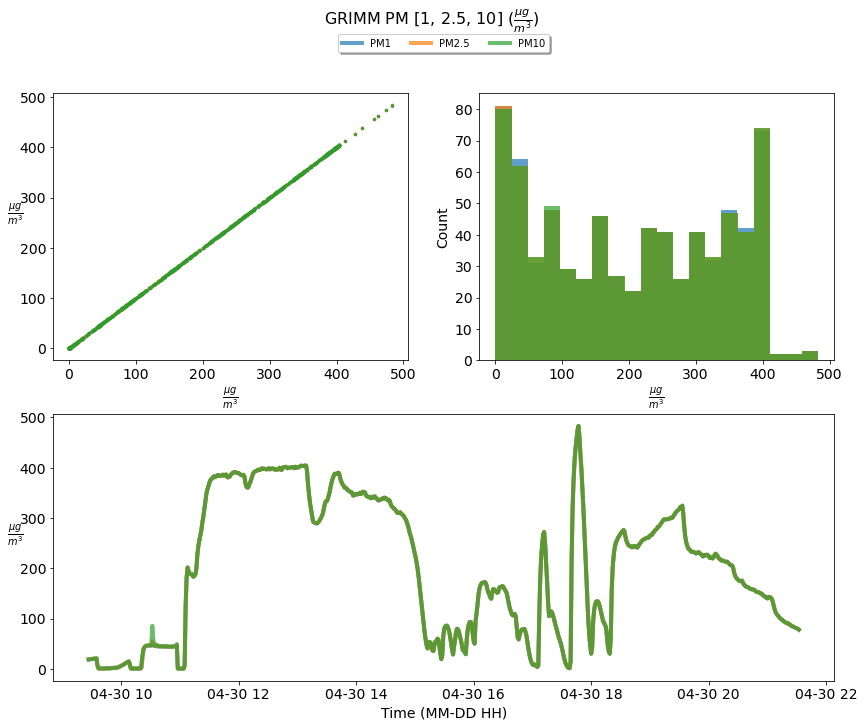

In [10]:
fig = plt.figure(figsize=(14, 12))
fig.autofmt_xdate()
xfmt = DateFormatter("%m-%d %H:00")
alpha = 0.7

fig.suptitle(r"GRIMM PM [1, 2.5, 10] ($\frac{\mu g}{m^3}$)", fontsize=16)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df_final.index,df_final['PM1 [ug/m3]'], lw = 4.0, label = 'PM1', alpha = alpha,color = colors[0])
ax.plot(df_final.index,df_final['PM2.5 [ug/m3]'], lw = 4.0, label = 'PM2.5',alpha = alpha, color = colors[1])
ax.plot(df_final.index,df_final['PM10 [ug/m3]'], lw = 4.0, label = 'PM10', alpha = alpha,color = colors[2])

ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 2.44),
    ncol=6,
    fancybox=True,
    shadow=True,
)
ax = fig.add_subplot(2, 2, 1)
size = 6
ax.scatter(df_final['PM1 [ug/m3]'],df_final['PM1 [ug/m3]'], s=size, alpha = alpha,color = colors[0])
ax.scatter(df_final['PM2.5 [ug/m3]'], df_final['PM2.5 [ug/m3]'], s=size,alpha = alpha, color = colors[1])
ax.scatter(df_final['PM10 [ug/m3]'], df_final['PM10 [ug/m3]'], s=size, alpha = alpha,color = colors[2])

ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

ax = fig.add_subplot(2, 2, 2)
bins = 20
ax.hist(df_final['PM1 [ug/m3]'],bins,alpha = alpha, color = colors[0], zorder = 10)
ax.hist(df_final['PM2.5 [ug/m3]'],bins,alpha = alpha, color = colors[1], zorder = 10)
ax.hist(df_final['PM10 [ug/m3]'],bins,alpha = alpha, color = colors[2], zorder = 10)

ax.set_ylabel('Count')
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

Figure 4: A time series of the  GRIMM sensor PM [1, 2.5, 10] incremented from 2021-04-30 09:27:00 until 2021-04-30 21:36:00. 

### Plot counts of particle sizes averaged over time.

[Text(0, 0, '0.25 um'),
 Text(1, 0, '0.28 um'),
 Text(2, 0, '0.30 um'),
 Text(3, 0, '0.35 um'),
 Text(4, 0, '0.40 um'),
 Text(5, 0, '0.45 um'),
 Text(6, 0, '0.50 um'),
 Text(7, 0, '0.58 um'),
 Text(8, 0, '0.65 um'),
 Text(9, 0, '0.70 um'),
 Text(10, 0, '0.80 um'),
 Text(11, 0, '1.00 um'),
 Text(12, 0, '1.30 um'),
 Text(13, 0, '1.60 um'),
 Text(14, 0, '2.00 um'),
 Text(15, 0, '2.50 um'),
 Text(16, 0, '3.00 um'),
 Text(17, 0, '3.50 um'),
 Text(18, 0, '4.00 um'),
 Text(19, 0, '5.00 um'),
 Text(20, 0, '6.50 um'),
 Text(21, 0, '7.50 um'),
 Text(22, 0, '8.50 um'),
 Text(23, 0, '10.00 um'),
 Text(24, 0, '12.50 um'),
 Text(25, 0, '15.00 um'),
 Text(26, 0, '17.50 um'),
 Text(27, 0, '20.00 um'),
 Text(28, 0, '25.00 um'),
 Text(29, 0, '30.00 um'),
 Text(30, 0, '32.00 um')]

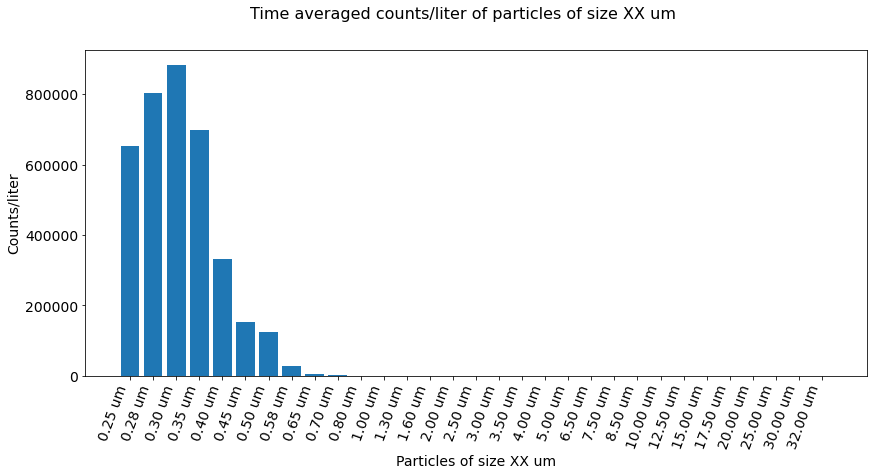

In [11]:

var_list = list(df_final)[6:37]
var_labels = [var[:-2] for var in var_list]
df_final_mean = df_final[var_list].mean()

fig = plt.figure(figsize=(14, 6))
fig.suptitle("Time averaged counts/liter of particles of size XX um", fontsize=16)
ax = fig.add_subplot(1, 1, 1)
ax.bar(var_labels,df_final_mean)
ax.set_ylabel('Counts/liter')
ax.set_xlabel('Particles of size XX um')
ax.set_xticklabels(var_labels, rotation=70, ha='right')

Figure 5 Time-averaged counts/liter of particles of size XX um, as measured by the GRIMM sensor.
<br>
<br>

As depicted above all air-borne salt particles are 0.7 um or lower, with the majority at 0.3 um, implying that no deviation in PM concentration for PM 1.0, 2.5, and 10 values should exist. Comparing the GRIMM measured PM [1.0, 2.5, 10] supports this consideration.
<br>
<br>
Based upon the above it is believed that our UBC-PM sensors aren’t sensitive enough to delineate clusters of small particles from larger particles. As a result, higher concentration values in PM 2.5 and 10 are indicated. More work needs to be done to support this statement.

## Calibration
We will construct a multilayer perceptron (MLP) model to try and correct our UBC-Pm sensor inaccuracy. We will test our UBC-PM-03 sensors using measured PM2.5 and particle counts at 03um, 05um, 10um 25um 50um, and 100um as input in the MLP. The MLP target will be the GRIMM PM2.5

### Correct PM 2.5 with an linear regrestion.
# First, open another dataset and merge with the one we have been using.

In [12]:
# open all ubc_pm datafiles into a list
ubc_list = [prepare_df(f"/UBC-PM-0{i}/", '20210502') for i in range(1,6)]
## combine them to one dataframe
df_ubc = reduce(lambda x, y: pd.merge(x, y, on='rtctime'), ubc_list)
## drop odd character header added when combining
df_ubc.columns = df_ubc.columns.str.replace('_y', '')
## find the ubc dataframe with the lowest time stapms
min_ubc = np.argmin([len(ubc_list[i]) for i in range(len(ubc_list))])
## open the GRIMM dataset and restrict time to smallest ubc pm timeseries
df_grim = open_grimm('20210502', ubc_list[min_ubc])
## combine all the ubc pm dataframes with the grimm dataframe
df_final2 = pd.merge(left=df_grim, right=df_ubc, left_index=True, right_index=True, how='left')
## drop odd character header added when combining
df_final2.columns = df_final2.columns.str.replace('_y', '')
## drop the last 30 mins for this datafile as the sensors were removed form the glass chamber but still sampling
df_final2 = df_final2[:'2021-05-02T18:50']

### Correct PM 2.5 with an MLP
First, subset dataframe and normalize

In [13]:
pm = '2.5' 
pm_u = pm.replace('.', '')
# pm = pm[0]
ubc_pm = 'UBC_PM_03_pm'
keep_vars = [f'PM{pm} [ug/m3]', f'{ubc_pm}{pm_u}_env', f'{ubc_pm[:-3]}_particles_03um', f'{ubc_pm[:-3]}_particles_05um', f'{ubc_pm[:-3]}_particles_10um', f'{ubc_pm[:-3]}_particles_25um', f'{ubc_pm[:-3]}_particles_50um', f'{ubc_pm[:-3]}_particles_100um']
df = df_final.drop(columns=[col for col in df_final if col not in keep_vars])
# df[f'{ubc_pm}{pm_u}_env2'] = df[f'{ubc_pm}{pm_u}_env']
df.tail()

,PM2.5 [ug/m3],UBC_PM_03_pm25_env,UBC_PM_03_particles_03um,UBC_PM_03_particles_05um,UBC_PM_03_particles_10um,UBC_PM_03_particles_25um,UBC_PM_03_particles_50um,UBC_PM_03_particles_100um
2021-04-30 21:28:00,82.3,123.391304,20559.913043,6086.869565,1308.282609,57.782609,5.173913,4.521739
2021-04-30 21:29:00,81.3,117.155556,20010.400000,5856.111111,1248.311111,64.200000,8.800000,5.155556
2021-04-30 21:30:00,80.7,119.413043,19804.500000,5807.152174,1254.195652,73.739130,7.565217,4.173913
2021-04-30 21:31:00,79.7,116.304348,19685.413043,5788.217391,1227.217391,59.282609,8.086957,6.434783
2021-04-30 21:32:00,78.1,114.217391,19493.543478,5707.108696,1207.956522,66.260870,11.000000,8.043478


Normalize data and print

In [14]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# split up data
y = scaled[:,0]
x = scaled[:,1:]

try:
  # load mlp
  with open(str(data_dir)+f'/mlps/{ubc_pm}{pm_u}.pkl', 'rb') as fid:
      model = pickle.load(fid)
  print(f'found mpl for {ubc_pm}{pm_u}')
except:
  print(f'can not find mpl for {ubc_pm}{pm_u}, building...')
  nhn = 8 
  hidden_layers = 2
  model = MLPRegressor(
      hidden_layer_sizes=(nhn, hidden_layers),
      verbose=False,
      max_iter=1500,
      early_stopping=True,
      validation_fraction=0.2 ,
      batch_size=32,
      solver="adam" ,
      activation="relu",
      learning_rate_init=0.0001,
  )

  model.fit(x, y)  # train the model
  # save the mlp
  with open(str(data_dir)+f'/mlps/{ubc_pm}{pm_u}.pkl', 'wb') as fid:
      pickle.dump(model, fid)    



found mpl for UBC_PM_03_pm25


Open a dataset from another days comparisons of the GRIMM v UBC-PMs

In [15]:
# open all ubc_pm datafiles into a list
ubc_list = [prepare_df(f"/UBC-PM-0{i}/", '20210502') for i in range(1,6)]
## combine them to one dataframe
df_ubc = reduce(lambda x, y: pd.merge(x, y, on='rtctime'), ubc_list)
## drop odd character header added when combining
df_ubc.columns = df_ubc.columns.str.replace('_y', '')
## find the ubc dataframe with the lowest time stapms
min_ubc = np.argmin([len(ubc_list[i]) for i in range(len(ubc_list))])
## open the GRIMM dataset and restrict time to smallest ubc pm timeseries
df_grim = open_grimm('20210502', ubc_list[min_ubc])
## combine all the ubc pm dataframes with the grimm dataframe
df_final2 = pd.merge(left=df_grim, right=df_ubc, left_index=True, right_index=True, how='left')
## drop odd character header added when combining
df_final2.columns = df_final2.columns.str.replace('_y', '')
## drop the last 30 mins for this datafile as the sensors were removed form the glass chamber but still sampling
df_final2 = df_final2[:'2021-05-02T18:50']

reduce dataframe to be only a few variable of interest..print last 5 rows

In [16]:
# keep_vars = [f'PM{pm} [ug/m3]', f'{ubc_pm}{pm_u}_env']
keep_vars = [f'PM{pm} [ug/m3]', f'{ubc_pm}{pm_u}_env', f'{ubc_pm[:-3]}_particles_03um', f'{ubc_pm[:-3]}_particles_05um', f'{ubc_pm[:-3]}_particles_10um', f'{ubc_pm[:-3]}_particles_25um', f'{ubc_pm[:-3]}_particles_50um', f'{ubc_pm[:-3]}_particles_100um']
df2 = df_final2.drop(columns=[col for col in df_final2 if col not in keep_vars])
# df2[f'{ubc_pm}{pm_u}_env2'] = df2[f'{ubc_pm}{pm_u}_env']
df2.tail()

,PM2.5 [ug/m3],UBC_PM_03_pm25_env,UBC_PM_03_particles_03um,UBC_PM_03_particles_05um,UBC_PM_03_particles_10um,UBC_PM_03_particles_25um,UBC_PM_03_particles_50um,UBC_PM_03_particles_100um
2021-05-02 18:46:00,139.1,260.733333,43740.866667,12995.000000,2722.688889,103.222222,16.177778,10.444444
2021-05-02 18:47:00,142.2,260.217391,43413.652174,12950.217391,2667.173913,113.000000,19.826087,15.304348
2021-05-02 18:48:00,124.6,239.066667,40453.000000,11988.222222,2443.888889,106.000000,11.555556,10.711111
2021-05-02 18:49:00,108.3,192.511111,33387.400000,9880.066667,1933.800000,56.044444,6.444444,3.511111
2021-05-02 18:50:00,105.5,182.413043,32692.891304,9600.586957,1645.673913,74.021739,8.608696,5.869565


Normalize this reduce dataframe and use our mlp model to correct to grimm

In [17]:
scaler2 = MinMaxScaler()
scaled2 = scaler2.fit_transform(df2)

# split up data
y2 = scaled2[:,0]
x2 = scaled2[:,1:]
y_predict = model.predict(
    x2
) 

Inverse transform or "unnormalize" data

In [18]:
y_predict  = np.column_stack((y_predict,x2))
unscaled = scaler.inverse_transform(y_predict)
df_final2[f'{ubc_pm}{pm_u}_cor'] = unscaled[:,0]

Plot corrected UBC PM 2.5 

Text(0.5, 0, '$\\frac{\\mu g}{m^3}$')

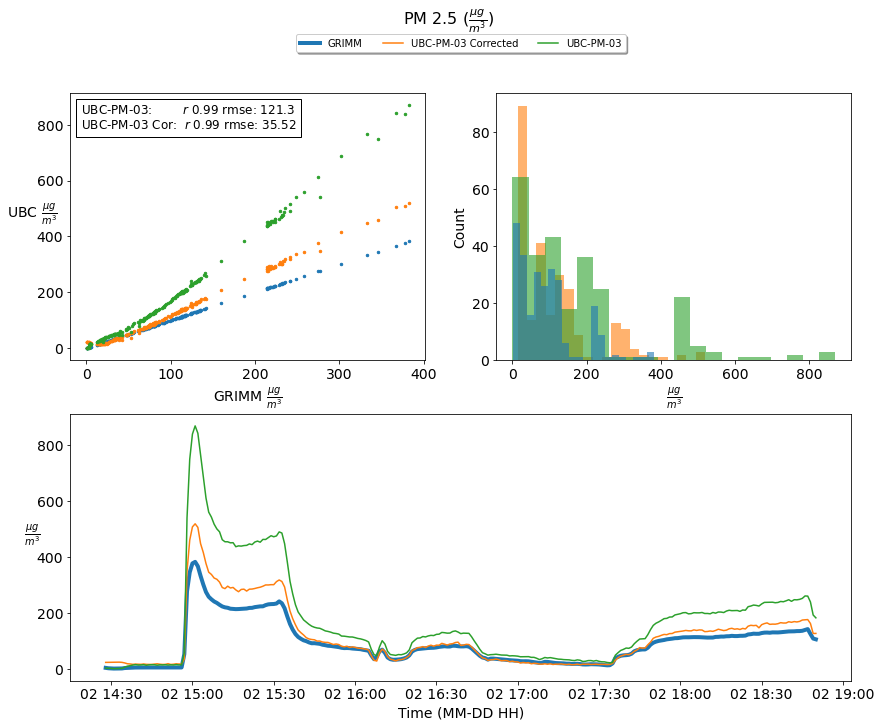

In [19]:

r2value_cor = round(
    stats.pearsonr(df_final2[f'PM{pm} [ug/m3]'].values, df_final2[f'{ubc_pm}{pm_u}_cor'].values)[0], 2
)
r2value = round(
    stats.pearsonr(df_final2[f'PM{pm} [ug/m3]'].values, df_final2[f'{ubc_pm}{pm_u}_env'].values)[0], 2
)
rmse_cor = str(
    round(
        mean_squared_error(
            df_final2[f'PM{pm} [ug/m3]'].values, df_final2[f'{ubc_pm}{pm_u}_cor'].values, squared=False
        ),
        2,
    )
)
rmse = str(
    round(
        mean_squared_error(
            df_final2[f'PM{pm} [ug/m3]'].values, df_final2[f'{ubc_pm}{pm_u}_env'].values, squared=False
        ),
        2,
    )
)
anchored_text = AnchoredText(
    "UBC-PM-03:        " + r"$r$ " + f"{r2value} rmse: {rmse}" + " \nUBC-PM-03 Cor:  " + r"$r$ " + f"{r2value_cor} rmse: {rmse_cor}"  ,
    loc="upper left",
    prop={"size": 12, "zorder": 10},
)


fig = plt.figure(figsize=(14, 12))
fig.autofmt_xdate()
xfmt = DateFormatter("%m-%d %H:00")
fig.suptitle(r"PM 2.5 ($\frac{\mu g}{m^3}$)", fontsize=16)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df_final2.index,df_final2[f'PM{pm} [ug/m3]'].values, lw = 4.0, label = 'GRIMM', color = colors[0])
ax.plot(df_final2.index,df_final2[f'{ubc_pm}{pm_u}_cor'], label = 'UBC-PM-03 Corrected', color = colors[1])
ax.plot(df_final2.index,df_final2[f'{ubc_pm}{pm_u}_env'].values, label = 'UBC-PM-03', color = colors[2])
ax.set_ylabel(r'$\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel('Time (MM-DD HH)')
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 2.44),
    ncol=6,
    fancybox=True,
    shadow=True,
)
ax = fig.add_subplot(2, 2, 1)
size = 6
ax.scatter(df_final2[f'PM{pm} [ug/m3]'], df_final2[f'PM{pm} [ug/m3]'], s=size, color = colors[0])
ax.scatter(df_final2[f'PM{pm} [ug/m3]'], df_final2[f'{ubc_pm}{pm_u}_cor'], s=size, color = colors[1])
ax.scatter(df_final2[f'PM{pm} [ug/m3]'], df_final2[f'{ubc_pm}{pm_u}_env'], s=size, color = colors[2])
ax.set_ylabel(r'UBC $\frac{\mu g}{m^3}$', rotation=0)
ax.set_xlabel(r'GRIMM $\frac{\mu g}{m^3}$')
ax.plot((0, 1), "r--", lw= 0.4)
ax.add_artist(anchored_text)

ax = fig.add_subplot(2, 2, 2)
bins = 20
alpha = 0.6
ax.hist(df_final2[f'PM{pm} [ug/m3]'],bins,alpha = alpha, color = colors[0], zorder = 10)
ax.hist(df_final2[f'{ubc_pm}{pm_u}_cor'],bins, alpha = alpha, color = colors[1])
ax.hist(df_final2[f'{ubc_pm}{pm_u}_env'],bins, alpha = alpha, color = colors[2])

ax.set_ylabel('Count')
ax.set_xlabel(r'$\frac{\mu g}{m^3}$')

While the MLP moves the PM2.5 concentration values in the correct direction, we recognize this is approach will not work when applied to our field measurements. Our current MLP model is trained from particular conditions with a narrow particle distribution size range. To make this more robust, we need to expose the sensors to a broader range of known particle compositions, sizes, and distributions in the lab.  